<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/model_descriptions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model Descriptions

In [1]:
!git clone https://github.com/dernameistegal/airbnb_price.git

fatal: destination path 'airbnb_price' already exists and is not an empty directory.


In [2]:
%cd airbnb_price
import sys
sys.path.append("/content/airbnb_price/custom_functions")
import general_utils as ut
import train_utils as train
device = ut.get_device()

/content/airbnb_price
cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla P100-PCIE-16GB


In [3]:
%%capture
!pip install transformers
!pip install requests
!pip install captum

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import fastprogress
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertModel
import torch.nn as nn
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading

### Explore the dataset

In [5]:
path = "/content/drive/MyDrive/Colab/airbnb/data/reviews/df.pickle"
data = pd.read_pickle(path)
input_ids, attention_masks, labels = data['desc_input_ids'], data['desc_attention_masks'], data['log_price']

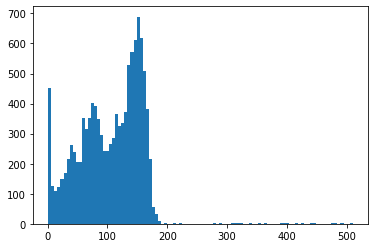

In [6]:
# TODO Visualize the length of the reviews in your dataset
def count_words(string):
    return len(string.split())

review_lengths = np.vectorize(count_words)(data['description_en'])

a = plt.hist(review_lengths, bins = 100)
plt.show()

In [7]:
%tensorflow_version 1.x
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

TensorFlow 1.x selected.


## Training, Validation, Test Split

Use 15% of the dataset as validation and test set, respectively. Use the other 70% for training.

In [8]:
train_ids, val_ids, test_ids = ut.train_val_test_split(data.index)  
ids_train, ids_val = np.stack(input_ids[train_ids]), np.stack(input_ids[val_ids])
labels_train, labels_val = np.stack(labels[train_ids]), np.stack(labels[val_ids])
masks_train, masks_val = np.stack(attention_masks[train_ids]), np.stack(attention_masks[val_ids])

In [9]:
# TODO: Print out the shapes of your splitted train, validation, and test set
# Hint: your validation set should contain 500 samples. How many tokens are
# included per sample? 

# (1) print the feature shapes
print(ids_train.shape)
print(ids_val.shape)

# (2) print the label shapes
print(labels_train.shape)
print(labels_val.shape)

# (3) print the attention mask shapes
print(masks_train.shape)
print(masks_val.shape)

(7982, 256)
(1711, 256)
(7982,)
(1711,)
(7982, 256)
(1711, 256)


## Create DataLoader

You can use `TensorDataset`, `torch.from_numpy(...)`, and `DataLoader(...)` to create Dataloaders for your dataset holding features, labels and attention masks. Make sure to shuffle your training data. Is shuffling required for the validation and test data?

In [10]:
# TODO
# create dataloaders
from torch.utils.data import TensorDataset, DataLoader
trainset = TensorDataset(torch.from_numpy(ids_train), torch.from_numpy(labels_train), torch.from_numpy(masks_train))
valset = TensorDataset(torch.from_numpy(ids_val), torch.from_numpy(labels_val), torch.from_numpy(masks_val))

b = 128
trainloader = DataLoader(trainset, shuffle=True, num_workers=2, batch_size=b)
valloader = DataLoader(valset, shuffle=False, num_workers=2, batch_size=b)

# Fine-tune BERT model

(This is a non-mandatory, fully optional task)

Can you improve performance by fine-tuning BERT in addition to training the readout classifier?

In [11]:
b = 32
trainloader = DataLoader(trainset, shuffle=True, num_workers=2, batch_size=b)
valloader = DataLoader(valset, shuffle=True, num_workers=2, batch_size=64)
sys.path.append("/content/airbnb_price/models")
from language_model import LanguageBertNet
!mkdir -p /content/checkpoints/

In [14]:
model = LanguageBertNet(fine_tune=True, with_attention_masks=True, cls_dropout_prob=0.5)
model = model.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 15)
result = train.run_training(model, optimizer, loss_fn, device, 30, trainloader, 
                            valloader, verbose=True, ntrain=1000, nval=1000, scheduler=scheduler)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Saving model...
Saving model...
Saving model...
Finished training after 6404 seconds.


In [16]:

def plot(title, label, training, validation, yscale='linear', legend=["Training", "Validation"],
         thinning=1, save_path=None, size=(5,4)):

    epoch_array = np.arange(0, len(training))
    training = training[::thinning]
    validation = validation[::thinning]
    epoch_array = epoch_array[::thinning]
    plt.figure(figsize=size)

    sns.set(style='ticks')
    plt.plot(epoch_array, training,linestyle='dashed', marker='o', zorder=-1)
    plt.plot(epoch_array, validation, linestyle='dashed', marker='o', zorder=-1)
    legend = [legend[0], legend[1]]
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title, fontsize=15)

    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight', format="svg", transparent=True)
    plt.show()


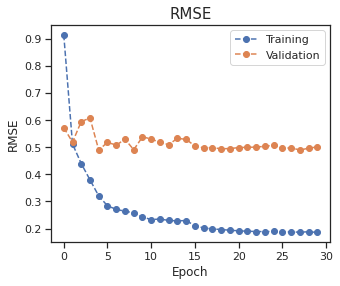

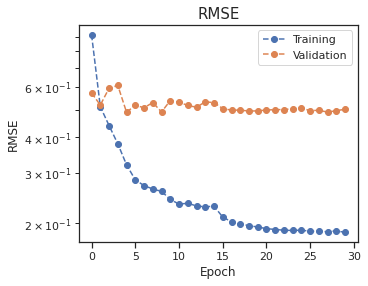

In [18]:
# plot train and test
train_losses, val_losses, train_rmse, val_rmse = result
plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='linear', save_path="/content/file0.svg")
plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='log')

In [19]:
model.load_state_dict(torch.load("/content/checkpoints/checkpoint.pt"))

<All keys matched successfully>

100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


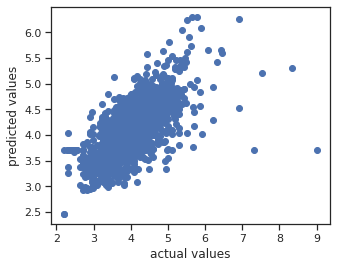

(0.6737884039979325, 7.834915749609444e-227)
The root mean squared error (MSE) on test set: 0.4897


In [23]:
# show correlation
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt

ys = []
ypreds = []

with torch.no_grad():
    model = model.eval()

    for ids, labels, masks in tqdm(valloader):
        ids, masks = ids.to(device), masks.to(device)
        y_pred = model(ids, masks)[0]
        y_pred = list(y_pred.detach().cpu())
        ypreds = ypreds + y_pred

        ys = ys + list(labels)


ys = np.array(ys)
ypreds = np.array(ypreds)
plt.figure(figsize=(5,4))
plt.scatter(ys, ypreds)
plt.ylabel("predicted values")
plt.xlabel("actual values")
plt.savefig(str("/content/file0.svg"), bbox_inches='tight', format="svg", transparent=True)
plt.show()
print(pearsonr(ys, ypreds))


from sklearn.metrics import mean_squared_error

mse = mean_squared_error(ys, ypreds)
print("The root mean squared error (MSE) on test set: {:.4f}".format(np.sqrt(mse)))

In [24]:

path ="/content/checkpoints/train_loss.npy"
np.save(path, train_losses)
path ="/content/checkpoints/val_loss.npy"
np.save(path, val_losses)

# do you want to save a checkpoint run this chunk
!mkdir -p /content/drive/MyDrive/Colab/airbnb/data/logs/description/best
!cp -r /content/checkpoints/ /content/drive/MyDrive/Colab/airbnb/data/logs/description/best

# Generate Embeddings

In [25]:
# load model
sys.path.append("/content/airbnb_price/models")
from language_model import LanguageBertNet
model = LanguageBertNet(fine_tune=False, with_attention_masks=True)
path = "/content/drive/MyDrive/Colab/airbnb/data/logs/description/best/checkpoints/checkpoint.pt"
model.load_state_dict(torch.load(path))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
input_ids, attention_masks, index = data['desc_input_ids'], data['desc_attention_masks'], data.index
ids = np.stack(input_ids)
masks = np.stack(attention_masks)
index = index.to_numpy()
dataset = TensorDataset(torch.from_numpy(ids), torch.from_numpy(index), torch.from_numpy(masks))
b = 128
loader = DataLoader(dataset, shuffle=False, num_workers=2, batch_size=b)

In [27]:
# generate embeddings
from tqdm import tqdm
embeddings = torch.empty((len(dataset), 100))
model.eval()
start = 0
indices = []
with torch.no_grad():
    for ids, index, masks in tqdm(loader):
        ids, masks = ids.to(device), masks.to(device)
        embedding = model.genembeddings(ids, masks)
        embedding = embedding.detach().cpu()
        stop = start + len(ids)
        embeddings[start:stop] = embedding
        start = stop
        indices = indices + list(index.numpy())

In [31]:
# save embeddings in pandas dataframe
embeddings[embeddings < 0] = 0
df = pd.Series(embeddings.numpy().tolist(), name="descriptions", index=indices)
path = "/content/drive/MyDrive/Colab/airbnb/data/embeddings/descriptions.pickle"
df.to_pickle(path)

# explain

In [42]:
len(text)

875

In [46]:
input_ids, price, mask = valset[1000]
text = tokenizer.decode(input_ids[mask.bool()])
print(text)
print(np.exp(price))
import explainability_utils as explain
attention = explain.pipeline(text, model, device)
attention = attention[0:4]
text = text[0:512]
explain.visualize_attention(text, attention)
len(text)

[CLS] the room has a spacious layout, is bright and cosy and one of the rooms in a shared flat with two roommates. we are open - minded, communicative, young people and hope you'll enjoy your stay with us! our flat is in a central location, with three different trams around, you can get to the center in about 10 minutes. the next underground station is about a five minute walk away. also a supermarket is right nearby. [SEP]
tensor(22.0000, dtype=torch.float64)
25.114412307739258


427